In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [4]:
df = pd.read_csv("data/clean/dataset.csv", index_col='idx')
df.head()

/var/folders/cl/wqxhc67j255bdr0rmv_bl3580000gn/T/ipykernel_68714/1957658052.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/clean/dataset.csv", index_col='idx')


,Start,End,kWh,Revenue,Station,PortNum,PortType,Adapter,Client,Tariff,MaxPower,Fishka,Latitude,Longitude,Type,ChargingTime
idx,,,,,,,,,,,,,,,,
0,2021-01-01 00:05:34,2021-01-01 00:31:22,6.033,27.15,209,3,Type 2 Plug,False,553804960,4.50,NaN,True,50.43104,30.39037,FAST,25.80
1,2021-01-01 01:40:37,2021-01-01 01:42:19,0.890,6.22,111,1,CHAdeMO,False,550843379,6.99,NaN,True,50.48207,30.48725,FAST,1.70
2,2021-01-01 02:12:35,2021-01-01 03:07:36,3.300,14.85,147,1,Type 2,False,540085134,4.50,NaN,True,49.24778,23.85610,SLOW,55.02
3,2021-01-01 02:32:21,2021-01-01 02:57:08,6.880,48.09,111,1,CHAdeMO,False,828881697,6.99,NaN,True,50.48207,30.48725,FAST,24.78
4,2021-01-01 03:39:03,2021-01-01 04:02:05,12.630,56.84,209,3,Type 2 Plug,False,553804960,4.50,NaN,True,50.43104,30.39037,FAST,23.03


In [5]:
df['Start'] = pd.to_datetime(df['Start'])
df['End'] = pd.to_datetime(df['End'])
df['Weekday'] = df['Start'].dt.day
df['Year'] = df['Start'].dt.year
df['Month'] = df['Start'].dt.month
df['Hour'] = df['Start'].dt.hour
df

,Start,End,kWh,Revenue,Station,PortNum,PortType,Adapter,Client,Tariff,MaxPower,Fishka,Latitude,Longitude,Type,ChargingTime,Weekday,Year,Month,Hour
idx,,,,,,,,,,,,,,,,,,,,
0,2021-01-01 00:05:34,2021-01-01 00:31:22,6.033,27.15,209,3,Type 2 Plug,False,553804960,4.50,NaN,True,50.431040,30.390370,FAST,25.80,1,2021,1,0
1,2021-01-01 01:40:37,2021-01-01 01:42:19,0.890,6.22,111,1,CHAdeMO,False,550843379,6.99,NaN,True,50.482070,30.487250,FAST,1.70,1,2021,1,1
2,2021-01-01 02:12:35,2021-01-01 03:07:36,3.300,14.85,147,1,Type 2,False,540085134,4.50,NaN,True,49.247780,23.856100,SLOW,55.02,1,2021,1,2
3,2021-01-01 02:32:21,2021-01-01 02:57:08,6.880,48.09,111,1,CHAdeMO,False,828881697,6.99,NaN,True,50.482070,30.487250,FAST,24.78,1,2021,1,2
4,2021-01-01 03:39:03,2021-01-01 04:02:05,12.630,56.84,209,3,Type 2 Plug,False,553804960,4.50,NaN,True,50.431040,30.390370,FAST,23.03,1,2021,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371666,2024-10-31 09:34:21,2024-10-31 10:37:24,73.572,1249.99,561,2,CCS 2/GBT DC,False,857230274,16.99,89.0,NaN,50.672440,26.271480,ULTRAFAST,63.05,31,2024,10,9
371667,2024-10-31 09:36:14,2024-10-31 10:01:05,36.793,625.11,550,1,CCS 2,False,503412773,16.99,119.0,NaN,50.319615,31.033856,ULTRAFAST,24.85,31,2024,10,9
371668,2024-10-31 09:36:48,2024-10-31 09:43:43,1.500,23.98,583,2,CHAdeMO,False,548310042,15.99,23.0,True,46.479330,30.690400,FAST,6.92,31,2024,10,9


In [6]:
df = pd.get_dummies(df, columns=['Type'], prefix='Type', drop_first=True)
dummy_cols = [c for c in df.columns if c.startswith(f"Type_")]
df[dummy_cols] = df[dummy_cols].astype(int)

In [7]:
df = pd.get_dummies(df, columns=['PortType'], prefix='PortType', drop_first=True)
dummy_cols = [c for c in df.columns if c.startswith(f"PortType_")]
df[dummy_cols] = df[dummy_cols].astype(int)

In [8]:
df = df[df['Latitude'].isna() == False]

In [9]:
features = ['Hour', 'Month', 'Year', 'Weekday', 'Latitude', 'Longitude', 'Tariff', 'PortNum', 'Type_SLOW', 'Type_ULTRAFAST', 'PortType_CCS 2/CCS 1', 'PortType_CCS 2/GBT DC', 'PortType_CHAdeMO', 'PortType_GB/T AC', 'PortType_GB/T DC', 'PortType_Type 1', 'PortType_Type 2', 'PortType_Type 2 Plug', 'PortType_Type 2/Type 1']
X = df[features]
y = df['kWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train['Latitude'].unique()

array([50.41829   , 50.645199  , 50.43104   , 49.75055   , 50.06559   ,
       50.46754   , 50.286393  , 46.47933   , 48.88627   , 50.41941   ,
       50.4947    , 50.34903   , 49.17718   , 50.354504  , 50.344203  ,
       48.95336   , 49.8358    , 48.566059  , 49.76575   , 50.22116   ,
       51.31633   , 48.91476   , 49.24778   , 50.319615  , 50.67244   ,
       48.31605   , 48.66523   , 48.62307   , 50.48207   , 46.53692   ,
       50.47138   , 48.567394  , 50.49169   , 48.53851   , 48.94194   ,
       49.03347   , 50.60912   , 50.53378   , 50.49857   , 48.41123   ,
       49.7827    , 46.574039  , 49.96054   , 48.4347    , 48.360587  ,
       50.8632    , 50.41115   , 48.360481  , 50.65631   , 49.95605   ,
       50.31563   , 50.02788   , 50.35851958, 48.581909  , 48.56355   ,
       49.81882   , 48.548346  ])

In [11]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [12]:
train_preds = lr_model.predict(X_train)
np.sqrt(mse(y_train, train_preds))

14.611976601587354

In [13]:
test_preds = lr_model.predict(X_test)
np.sqrt(mse(y_test, test_preds))

14.6184054847764

In [14]:
dt_model = DecisionTreeRegressor(max_depth=10)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [15]:
train_preds = dt_model.predict(X_train)
np.sqrt(mse(y_train, train_preds))

13.886207327880102

In [16]:
test_preds = dt_model.predict(X_test)
np.sqrt(mse(y_test, test_preds))

14.105303942852432

In [17]:
def get_folds(df, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        df.loc[val_idx, 'fold'] = fold
    return df

In [18]:
def get_train_valid_df(df, fold):
    train_df = df[df['fold'] != fold].copy()
    valid_df = df[df['fold'] == fold].copy()
    return train_df, valid_df

In [19]:
train = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [20]:
train

,Hour,Month,Year,Weekday,Latitude,Longitude,Tariff,PortNum,Type_SLOW,Type_ULTRAFAST,PortType_CCS 2/CCS 1,PortType_CCS 2/GBT DC,PortType_CHAdeMO,PortType_GB/T AC,PortType_GB/T DC,PortType_Type 1,PortType_Type 2,PortType_Type 2 Plug,PortType_Type 2/Type 1,kWh
idx,,,,,,,,,,,,,,,,,,,,
97498,13,9,2023,16,50.418290,29.839050,14.99,1,0,1,0,0,0,0,0,0,0,0,0,10.226
349084,15,10,2024,2,50.645199,26.200689,15.99,3,0,0,0,0,0,0,0,0,0,0,0,5.200
26070,8,8,2022,18,50.431040,30.390370,11.99,1,0,0,0,0,1,0,0,0,0,0,0,0.990
289406,8,7,2024,10,49.750550,24.015610,16.99,2,0,1,0,0,0,0,0,0,0,0,0,49.553
141461,9,11,2023,8,50.431040,30.390370,13.99,4,0,0,0,0,0,0,1,0,0,0,0,30.100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272378,13,6,2024,10,50.672440,26.271480,16.99,1,0,1,0,1,0,0,0,0,0,0,0,0.012
243021,17,4,2024,15,50.344203,30.418140,13.99,2,0,1,0,0,1,0,0,0,0,0,0,18.392
295750,9,7,2024,19,49.750550,24.015610,16.99,1,0,1,0,0,0,0,0,0,0,0,0,14.264


In [21]:
train.index = np.arange(0, len(train))

In [22]:
train = get_folds(train, n_folds=5)

In [23]:
train_df, valid_df = get_train_valid_df(train, 0)

In [24]:
max_depths = [4, 6, 8, 10, 12]
best_depth = None
best_rmse = np.inf
depth_rmses = []
best_model = None


for depth in max_depths:
    fold_rmses = []

    for fold in tqdm(range(5)):
        train_df, valid_df = get_train_valid_df(train, fold)


        X_train = train_df[features]
        y_train = train_df['kWh']

        X_valid = valid_df[features]
        y_valid = valid_df['kWh']

        model = DecisionTreeRegressor(max_depth=depth)
        model.fit(X_train, y_train)

        train_preds = model.predict(X_train)
        valid_preds = model.predict(X_valid)

        valid_rmse = np.sqrt(mse(y_valid, valid_preds))
        fold_rmses.append(valid_rmse)

    avg_rmse = np.mean(fold_rmses)
    depth_rmses.append(avg_rmse)

    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_depth = depth
        best_model = model

100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


In [25]:
best_rmse

14.148158992723427

In [26]:
best_depth

10

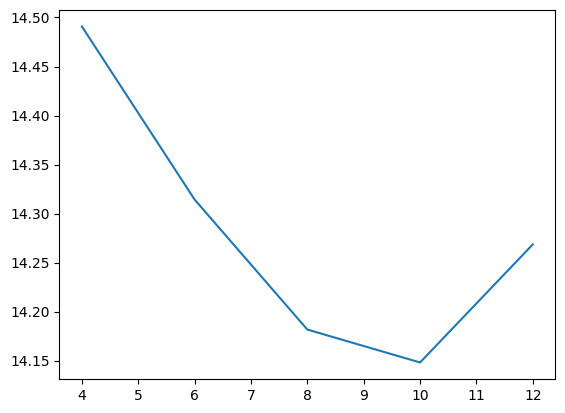

In [27]:
plt.plot(max_depths, depth_rmses)

In [28]:
test_preds = best_model.predict(X_test)
np.sqrt(mse(y_test, test_preds))

14.128507055402226

In [29]:
max_depths = [6, 8, 10]
best_depth = None
best_rmse = np.inf
depth_rmses = []
models = []


for max_depth in max_depths:
    fold_rmses = []
    fold_models = []

    for fold in tqdm(range(5)):
        train_df, valid_df = get_train_valid_df(train, fold)

        X_train = train_df[features]
        y_train = train_df['kWh']

        X_valid = valid_df[features]
        y_valid = valid_df['kWh']

        dtr = DecisionTreeRegressor(max_depth=max_depth)
        dtr.fit(X_train, y_train)

        y_pred_valid = dtr.predict(X_valid)
        fold_rmse = np.sqrt(mse(y_valid, y_pred_valid))
        fold_rmses.append(fold_rmse)
        fold_models.append(dtr)

    avg_rmse = np.mean(fold_rmses)
    depth_rmses.append(avg_rmse)
    print(f"max_depth={max_depth}, avg RMSE: {avg_rmse}")

    if avg_rmse <= best_rmse:
        best_rmse = avg_rmse
        best_depth = max_depth
        models = fold_models

print()
print(f"Best max_depth: {best_depth}")
print(f"Best avg RMSE: {best_rmse}")

100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


max_depth=6, avg RMSE: 14.31430374376994


100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


max_depth=8, avg RMSE: 14.181657007649415


100%|██████████| 5/5 [00:01<00:00,  2.83it/s]

max_depth=10, avg RMSE: 14.150391350392203

Best max_depth: 10
Best avg RMSE: 14.150391350392203


In [31]:
test_preds = np.zeros(len(X_test))

for model in models:
    preds = model.predict(X_test[features])
    test_preds += preds

test_preds /= 5
test_rmse = np.sqrt(mse(y_test, test_preds))
test_rmse

14.029337193399103

In [165]:
max_depths = [10, 15, 20]
list_estimators = [10, 15, 20]
best_depth = None
best_estimator = None
best_rmse = np.inf
depth_rmses = []
best_model = []


for depth in max_depths:
  for estimator in list_estimators:
    fold_rmses = []

    for fold in tqdm(range(5)):
        train_df, valid_df = get_train_valid_df(train, fold)


        X_train = train_df[features]
        y_train = train_df['kWh']

        X_valid = valid_df[features]
        y_valid = valid_df['kWh']

        model = RandomForestRegressor(n_estimators = estimator, max_depth=depth)
        model.fit(X_train, y_train)

        train_preds = model.predict(X_train)
        valid_preds = model.predict(X_valid)

        valid_rmse = np.sqrt(mse(y_valid, valid_preds))
        fold_rmses.append(valid_rmse)

    avg_rmse = np.mean(fold_rmses)
    depth_rmses.append(avg_rmse)
    print(f'Depth: {depth}, estimator: {estimator}, rmse: {avg_rmse}')

    if avg_rmse < best_rmse:
      best_rmse = avg_rmse
      best_depth = depth
      best_estimator = estimator
      best_model = model

100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


Depth: 10, estimator: 10, rmse: 14.020572978838425


100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


Depth: 10, estimator: 15, rmse: 14.01378519822048


100%|██████████| 5/5 [00:11<00:00,  2.33s/it]


Depth: 10, estimator: 20, rmse: 14.004187210663497


100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


Depth: 15, estimator: 10, rmse: 13.998027027390687


100%|██████████| 5/5 [00:11<00:00,  2.39s/it]


Depth: 15, estimator: 15, rmse: 13.932950187287293


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Depth: 15, estimator: 20, rmse: 13.91266933433413


100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Depth: 20, estimator: 10, rmse: 14.461852823263058


100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


Depth: 20, estimator: 15, rmse: 14.348070535549649


100%|██████████| 5/5 [00:20<00:00,  4.03s/it]

Depth: 20, estimator: 20, rmse: 14.289449640265266


In [166]:
train_preds = best_model.predict(X_test)
np.sqrt(mse(y_test, train_preds))

13.90683606714984